# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. VELOMITASAONA Francki Aldo  
2. RAKOTONDRAMANANA Mamisoa Désiré
3. RANAIVOARISOA Tanjoniaina Yrené
4. RAMAMPIANDRA Andriniaina Landry
5. RANDRIANANTENAINA Zaid Jacquot
6. RAKOTOMAMONJY Sitrainiaina José
7.


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

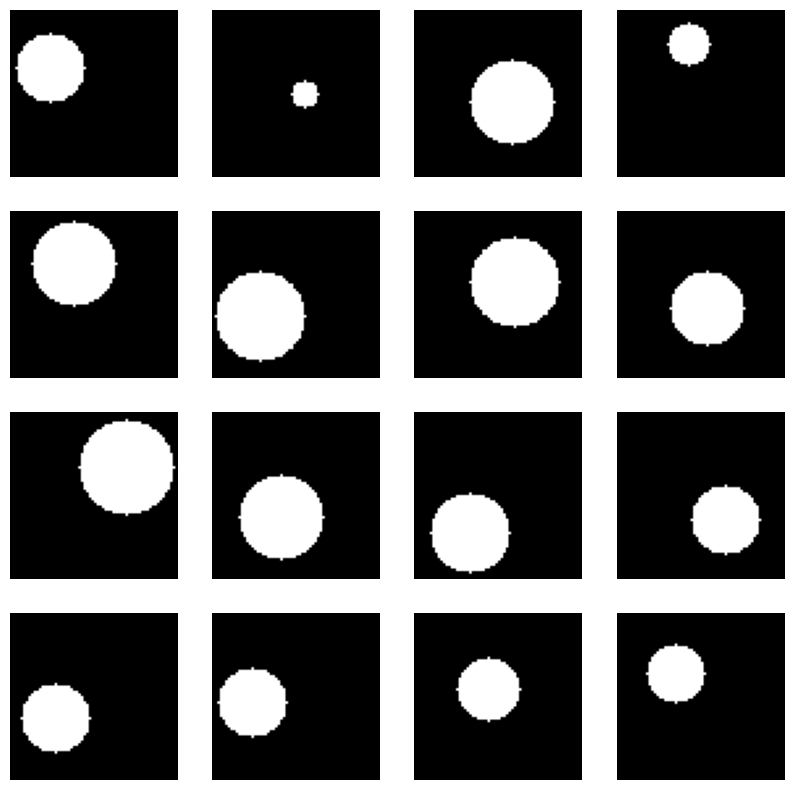

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)

Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [19]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 3)              │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [21]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - loss: 0.4590 - val_loss: 0.1508
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.1371 - val_loss: 0.1046
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1002 - val_loss: 0.0861
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0858 - val_loss: 0.0780
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0778 - val_loss: 0.0737
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0739 - val_loss: 0.0707
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0708 - val_loss: 0.0688
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0697 - val_loss: 0.0674
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0682 - val_loss: 0.0660
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0662 - val_loss: 0.0637
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0643 - val_loss: 0.0623
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


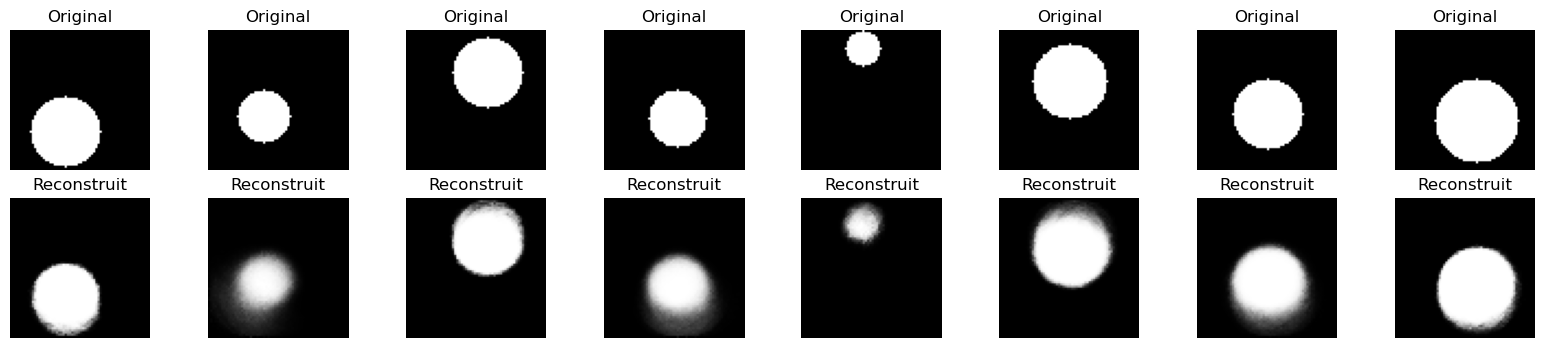

In [27]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [30]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 3)              │        49,155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16384)          │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [33]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.5351 - val_loss: 0.3121
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 948ms/step - loss: 0.3019 - val_loss: 0.1921
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - loss: 0.1729 - val_loss: 0.1034
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 986ms/step - loss: 0.0988 - val_loss: 0.0764
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 986ms/step - loss: 0.0741 - val_loss: 0.0600
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0576 - val_loss: 0.0457
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0441 - val_loss: 0.0367
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.0347 - val_loss: 0.0311
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0313 - val_loss: 0.0280
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 958ms/step - loss: 0.0266 - val_loss: 0.0242
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 0.0246 - val_loss: 0.0230
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


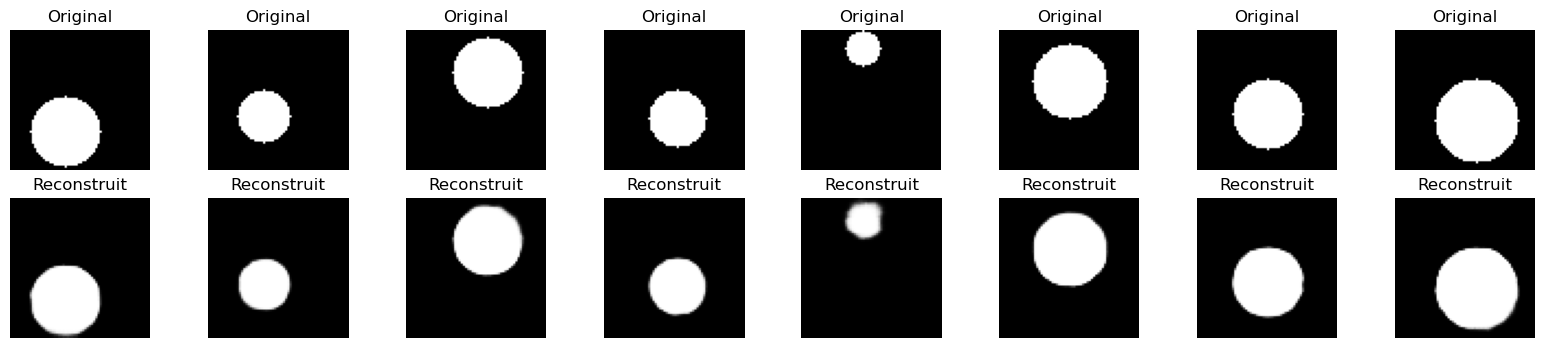

In [36]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

## REPONSE

# 1) Teste des deux model sur des images imparfaites (avec l'imperfection : bruit)

In [74]:
def ajouter_bruit(image, mean=0, std= np.random.rand()):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image+noise, 0, 1)
    return noisy_image

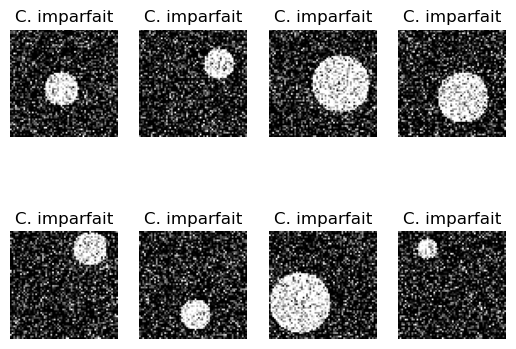

In [91]:
def generate_circle_image_imparfait(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)       

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)        

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)
    
    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0    

    return image

nombre_image_imparfaite = 100
def generate_dataset_imparfait(n_samples=nombre_image_imparfaite, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        img = ajouter_bruit(img)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# generer les images imparfaites
image_imparfaites = generate_dataset_imparfait(image_size=64)

# afficher quelque exemples des images imparfaites
for i in range(8):    
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image_imparfaites[i].squeeze(), cmap='gray')
    plt.title('C. imparfait')
    plt.axis('off')

# Visualisation des Reconstructions par model Autoencodeur Entièrement Connecté (Dense Layers)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


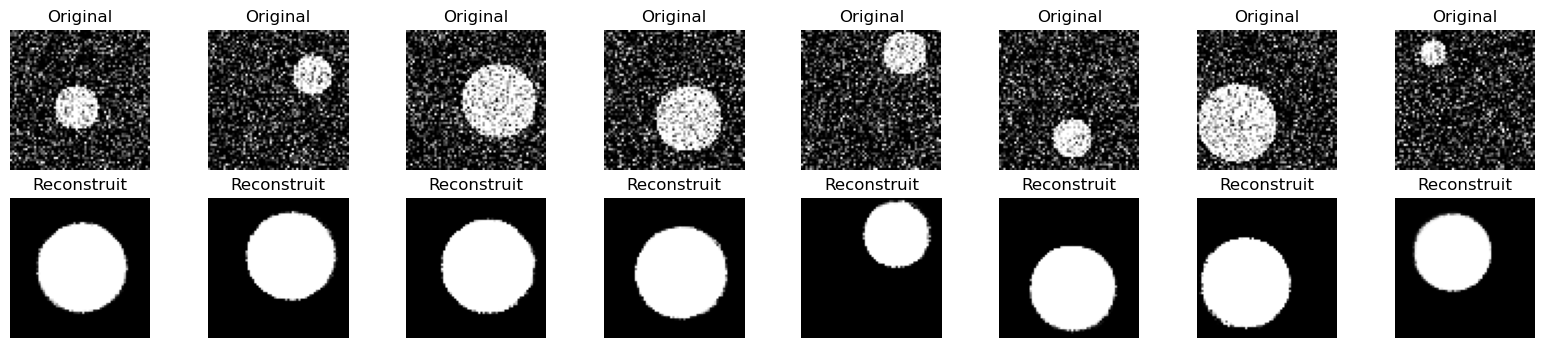

In [94]:
decoded_imgs_fc2 = autoencoder_fc.predict(image_imparfaites)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_imparfaites[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc2[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

# Visualisation des Reconstructions par model Autoencodeur Convolutionnel

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


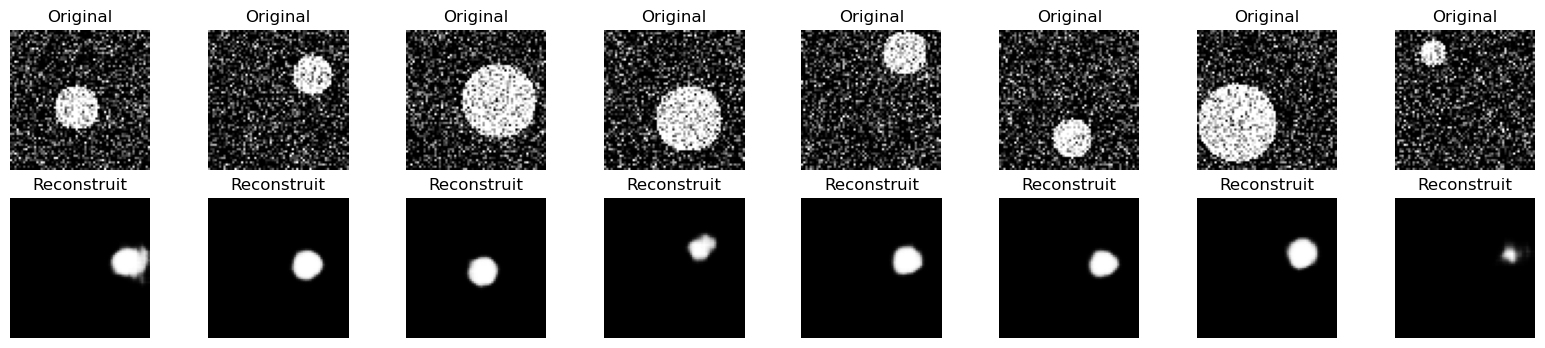

In [97]:
decoded_imgs_conv2 = autoencoder_conv.predict(image_imparfaites)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_imparfaites[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv2[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

## Interpretation

D'après les résultats, la reconstruction d'images bruitées par l'Autoencodeur convolutif est plus efficace que l'Autoencodeur Entièrement Connecté (Dense Layers) pour supprimer le bruit et reconstruire les images d'origine. L'Autoencodeur Entièrement Connecté (Dense Layers) ne capturent pas aussi bien les structures spatiales en raison de leur structure pleinement connectée. L'utilisation de convolutions permet de mieux apprendre les motifs locaux et de mieux restaurer les images bruitées.

Pour conclure, pour réduire les bruits et reconstruire des images de meilleure qualité, l'autoencodeur convolutif est le meilleur choix.

# 2) Amelioration du model Autoencodeur Entièrement Connecté (Dense Layers)

In [111]:
input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(512, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(512, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)
autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_fc.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 3)              │         1,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 64, 64, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,202,499 (16.03 MB)

 Trainable params: 4,202,499 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

# Entrainement

In [114]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=100,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.4243 - val_loss: 0.1457
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.1317 - val_loss: 0.0930
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0871 - val_loss: 0.0771
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.0758 - val_loss: 0.0705
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0719 - val_loss: 0.0668
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0677 - val_loss: 0.0636
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0631 - val_loss: 0.0586
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0574 - val_loss: 0.0520
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0501 - val_loss: 0.0437
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0421 - val_loss: 0.0379
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0362 - val_loss: 0.0324
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━

# Revisualisation des Reconstructions par model Autoencodeur Entièrement Connecté (Dense Layers)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


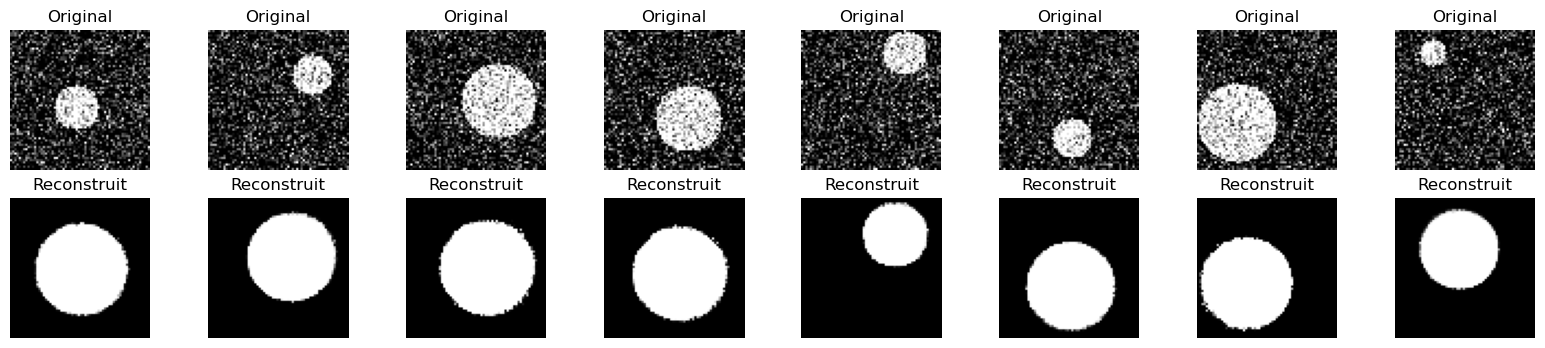

In [109]:
decoded_imgs_fc2 = autoencoder_fc.predict(image_imparfaites)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_imparfaites[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc2[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

# 3) Selon les expériences menées dans ce notebook :
Il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail car pour avoir plus d'information capturées, on a besoin d'un espace de latent de plus important, il permet une meilleur amelioration de la reconstruction et la generation. De l'autre côté, un espace latent plus grand offre moins de perte d'information.